In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [12]:
EPS = 1e-4

In [13]:
def compare_models(results_list, compare_lr=None, baseline=None, title="F1 Score by Layer"):
    results_dir = os.path.join(os.getcwd(), "results")
    for result in results_list:
        result_dir = os.path.join(results_dir, result)
        ccs_f1s = np.load(os.path.join(result_dir, "ccs_f1s.npy"))
        plt.scatter(range(len(ccs_f1s)), ccs_f1s, label=result)
        #plt.plot(range(len(ccs_f1s)), ccs_f1s)

    if compare_lr:
        result_dir = os.path.join(os.getcwd(), f"results/{compare_lr}")
        lr_f1s = np.load(os.path.join(result_dir, "lr_f1s.npy"))
        plt.plot(range(len(lr_f1s)), lr_f1s, label=f"{compare_lr} LR baseline", color="pink")

    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.05, 1))

    if baseline:
        plt.axhline(y=baseline, color="pink", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("F1 Score")

    plt.show()

In [14]:
def plot_lr_ccs_diffs(results_list, baseline=None, title="Lr vs. CCS F1 Difference by Layer"):
    results_dir = os.path.join(os.getcwd(), "results")
    for result in results_list:
        result_dir = os.path.join(results_dir, result)
        lr_f1s = np.load(os.path.join(result_dir, "lr_f1s.npy"))
        ccs_f1s = np.load(os.path.join(result_dir, "ccs_f1s.npy"))
        diff_f1s = lr_f1s - ccs_f1s
        plt.scatter(range(len(diff_f1s)), diff_f1s, label=result)

    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.05, 1))

    if baseline:
        plt.axhline(y=baseline, color="pink", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("LR F1 - CCS F1")

    plt.show()

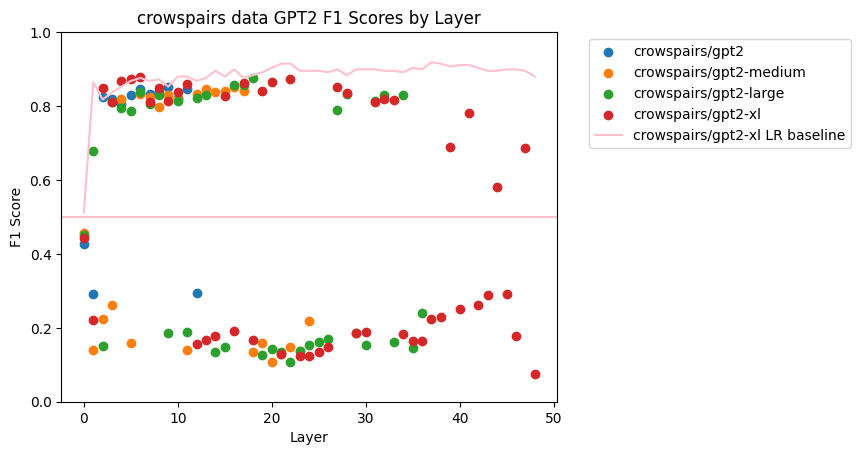

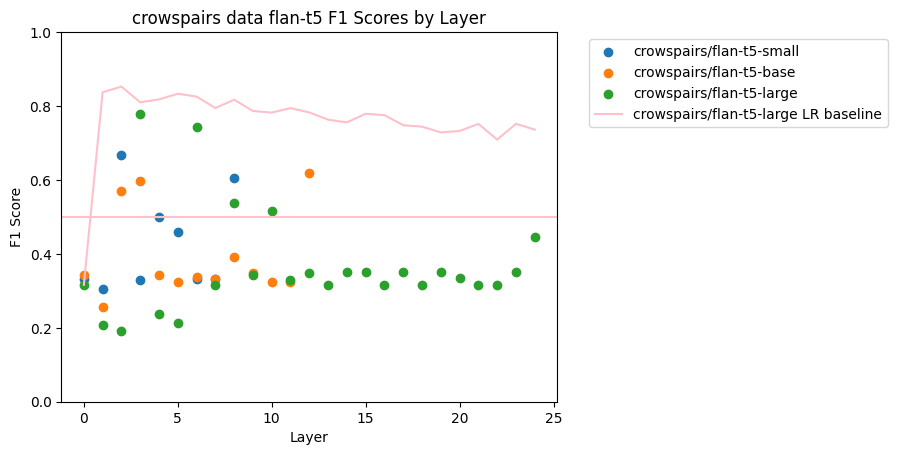

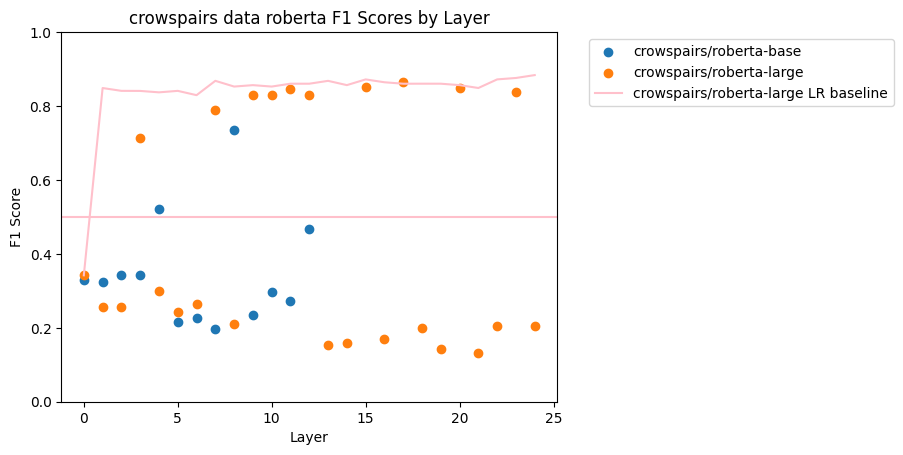

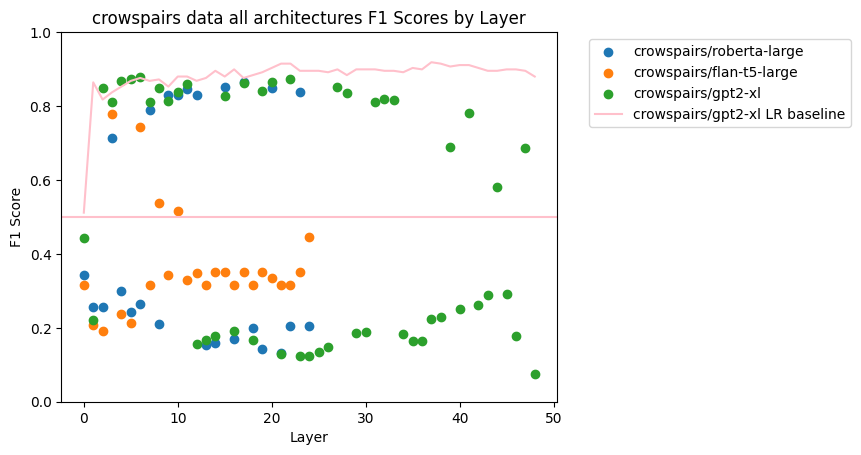

In [15]:
crowspairs_gpt2_list = ["crowspairs/gpt2", "crowspairs/gpt2-medium", "crowspairs/gpt2-large", "crowspairs/gpt2-xl"]
crowspairs_gpt2_compare_lr = "crowspairs/gpt2-xl"
compare_models(crowspairs_gpt2_list, compare_lr=crowspairs_gpt2_compare_lr, baseline=0.5, title="crowspairs data GPT2 F1 Scores by Layer")

crowspairs_flan_list = ["crowspairs/flan-t5-small", "crowspairs/flan-t5-base", "crowspairs/flan-t5-large"]
crowspairs_flan_compare_lr = "crowspairs/flan-t5-large"
compare_models(crowspairs_flan_list, compare_lr=crowspairs_flan_compare_lr, baseline=0.5, title="crowspairs data flan-t5 F1 Scores by Layer")

crowspairs_roberta_list = ["crowspairs/roberta-base", "crowspairs/roberta-large"]
crowspairs_roberta_compare_lr = "crowspairs/roberta-large"
compare_models(crowspairs_roberta_list, compare_lr=crowspairs_roberta_compare_lr, baseline=0.5, title="crowspairs data roberta F1 Scores by Layer")

crowspairs_all_list = ["crowspairs/roberta-large", "crowspairs/flan-t5-large", "crowspairs/gpt2-xl"]
crowspairs_all_compare_lr = "crowspairs/gpt2-xl"
compare_models(crowspairs_all_list, compare_lr=crowspairs_all_compare_lr, baseline=0.5, title="crowspairs data all architectures F1 Scores by Layer")